In [105]:
# Make plots of the deviation in treatment vs mortality, stratified for different subcohorts of patients
# those with high SOFA: extract points where SOFA > 15
# those with low SOFA: extract points where SOFA < 5
# those with middling SOFA: between 5 and 15
# Plot variation over time?

In [106]:
%matplotlib inline
import pandas as pd
import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt

In [107]:
df_orig = pd.read_csv('../data/MKdataset07Feb17.csv')

In [108]:
df_train = pd.read_csv('../data/rl_train_data_final_cont.csv')

In [109]:
df_test = pd.read_csv('../data/rl_test_data_final_cont.csv')

In [110]:
df_train_orig = df_orig[df_orig['icustayid'].isin(df_train['icustayid'].unique())]

In [111]:
df_test_orig = df_orig[df_orig['icustayid'].isin(df_test['icustayid'].unique())]

In [112]:
df_test.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0.000000,33,7214126400,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.883180,0.838839,0.834329,0.776672,0.585147,0.0,4.0,-0.025
1,0.222560,33,7214140800,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.888664,0.848773,0.839133,0.797009,0.592405,0.0,4.0,-0.025
2,0.356608,33,7214155200,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.894069,0.854142,0.842937,0.779852,0.601449,0.0,4.0,-0.025
3,0.452837,33,7214169600,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.898397,0.839183,0.845526,0.746598,0.609910,0.0,4.0,-0.025
4,0.527957,33,7214184000,0.0,0.669454,0.357143,0.0,1,1,0.247458,...,0.0,0.0,0.901804,0.821399,0.848365,0.758993,0.615787,0.0,4.0,-0.625


In [113]:
df_test_orig.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,mechvent,SOFA,SIRS,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev
41,1,33,7214126400,0,24524.747419,5.0,0,1,1,73.0,...,1,2,1,0.0,0.0,10794.791767,725.000000,5686.0,300.0,5108.791767
42,2,33,7214140800,0,24524.747419,5.0,0,1,1,73.0,...,1,2,1,0.0,0.0,11600.277233,805.485467,6056.0,370.0,5544.277233
43,3,33,7214155200,0,24524.747419,5.0,0,1,1,73.0,...,1,2,1,0.0,0.0,12452.925233,852.648000,6366.0,310.0,6086.925233
44,4,33,7214169600,0,24524.747419,5.0,0,1,1,73.0,...,1,2,1,0.0,0.0,13180.573233,727.648000,6586.0,220.0,6594.573233
45,5,33,7214184000,0,24524.747419,5.0,0,1,1,73.0,...,1,2,1,0.0,0.0,13783.221233,602.648000,6836.0,250.0,6947.221233


In [114]:
#  Extract out the interventions from the training dataset and find the medians for each dosage - these
#  represent the continuous analog of the chosen actions

In [115]:
interventions = df_train_orig[["max_dose_vaso", "input_4hourly_tev"]]
interventions.head()

,max_dose_vaso,input_4hourly_tev
0,0.0,2100.0
1,0.0,1999.0
2,0.0,105.0
3,0.0,60.0
4,0.0,60.0


In [116]:
adjusted_vaso = interventions["max_dose_vaso"][interventions["max_dose_vaso"] >0]
adjusted_iv = interventions["input_4hourly_tev"][interventions["input_4hourly_tev"]>0]

In [117]:
vaso_vals = [0]
vaso_vals.extend(adjusted_vaso.quantile([0.125,0.375,0.625,0.875]))
iv_vals = [0]
iv_vals.extend(adjusted_iv.quantile([0.125,0.375,0.625,0.875]))

In [118]:
def sliding_mean(data_array, window=1):
    new_list = []
    for i in range(len(data_array)):
        indices = range(max(i - window + 1, 0),
                        min(i + window + 1, len(data_array)))
        avg = 0
        for j in indices:
            avg += data_array[j]
        avg /= float(len(indices))
        new_list.append(avg)     
    return np.array(new_list)

In [119]:
#  Next two cells - can change to load the correct phys/agent actions we want in the plots

In [120]:
phys_actions = pickle.load(open( "../continuous/sarsa_phys/phys_actions_test.p", "rb" ))

In [121]:
autoencode_actions = pickle.load(open( "../continuous/dqn_normal/dqn_normal_actions_test.p", "rb" ))
deeprl2_actions = pickle.load(open( "../continuous/dqn_normal/dqn_normal_actions_test.p", "rb" ))

In [122]:
# Add in the actions selected to the df_test_orig dataframe. This helps with the stratified analysis afterwards
df_test_orig['autoencode_actions'] = autoencode_actions
df_test_orig['deeprl2_actions'] = deeprl2_actions
df_test_orig['phys_actions'] = phys_actions

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [123]:
# Perform stratification based on what we're looking for. Uncomment the fields that are unwanted.

# Low SOFA
# df_test_orig = df_test_orig[df_test_orig['SOFA'] <= 5]

# # Middling SOFA
# df_test_orig = df_test_orig[df_test_orig['SOFA'] > 5]
# df_test_orig = df_test_orig[df_test_orig['SOFA'] < 15]

# # High SOFA
df_test_orig = df_test_orig[df_test_orig['SOFA'] >= 15]

In [124]:
# Now re-select the phys_actions, autoencode_actions, and deeprl2_actions based on the statified dataset
autoencode_actions = df_test_orig['autoencode_actions'].values
deeprl2_actions = df_test_orig['deeprl2_actions'].values
phys_actions = df_test_orig['phys_actions'].values

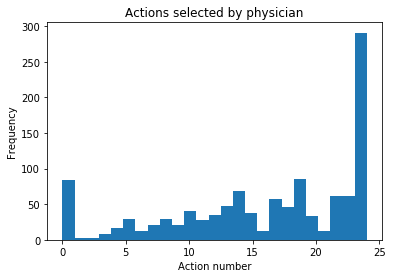

In [125]:
_ = plt.hist(phys_actions, bins=25)
plt.title("Actions selected by physician")
plt.xlabel("Action number")
plt.ylabel("Frequency")

In [126]:
inv_action_map = {}
count = 0
for i in range(5):
    for j in range(5):
        inv_action_map[count] = [i,j]
        count += 1

In [127]:
phys_actions_tuple = [None for i in range(len(phys_actions))]
deeprl2_actions_tuple = [None for i in range(len(phys_actions))]
autoencode_actions_tuple = [None for i in range(len(phys_actions))]                                          

for i in range(len(phys_actions)):
    phys_actions_tuple[i] = inv_action_map[phys_actions[i]]
    deeprl2_actions_tuple[i] = inv_action_map[deeprl2_actions[i]]
    autoencode_actions_tuple[i] = inv_action_map[autoencode_actions[i]]

In [128]:
phys_actions_tuple = np.array(phys_actions_tuple)
deeprl2_actions_tuple = np.array(deeprl2_actions_tuple)
autoencode_actions_tuple = np.array(autoencode_actions_tuple)

In [129]:
phys_actions_iv = phys_actions_tuple[:,0]
phys_actions_vaso = phys_actions_tuple[:,1]
hist, x_edges, y_edges = np.histogram2d(phys_actions_iv, phys_actions_vaso, bins=5)

In [130]:
deeprl2_actions_iv = deeprl2_actions_tuple[:,0]
deeprl2_actions_vaso = deeprl2_actions_tuple[:,1]
hist2, _, _ = np.histogram2d(deeprl2_actions_iv, deeprl2_actions_vaso, bins=5)

In [131]:
autoencode_actions_iv = autoencode_actions_tuple[:,0]
autoencode_actions_vaso = autoencode_actions_tuple[:,1]
hist3, _, _ = np.histogram2d(autoencode_actions_iv, autoencode_actions_vaso, bins=5)

In [132]:
x_edges = np.arange(-0.5,5)
y_edges = np.arange(-0.5,5)

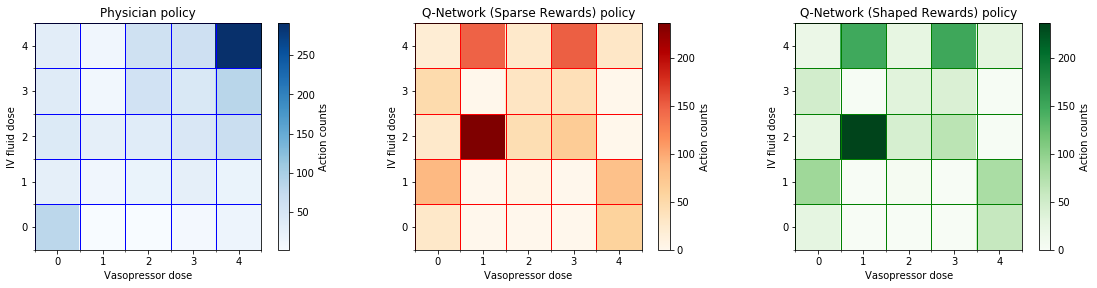

In [133]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
ax1.imshow(np.flipud(hist), cmap="Blues",extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
ax2.imshow(np.flipud(hist2), cmap="OrRd", extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
ax3.imshow(np.flipud(hist3), cmap="Greens", extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])

# ax1.grid(color='b', linestyle='-', linewidth=1)
# ax2.grid(color='r', linestyle='-', linewidth=1)
# ax3.grid(color='g', linestyle='-', linewidth=1)

# Major ticks
ax1.set_xticks(np.arange(0, 5, 1));
ax1.set_yticks(np.arange(0, 5, 1));
ax2.set_xticks(np.arange(0, 5, 1));
ax2.set_yticks(np.arange(0, 5, 1));
ax3.set_xticks(np.arange(0, 5, 1));
ax3.set_yticks(np.arange(0, 5, 1));

# Labels for major ticks
ax1.set_xticklabels(np.arange(0, 5, 1));
ax1.set_yticklabels(np.arange(0, 5, 1));
ax2.set_xticklabels(np.arange(0, 5, 1));
ax2.set_yticklabels(np.arange(0, 5, 1));
ax3.set_xticklabels(np.arange(0, 5, 1));
ax3.set_yticklabels(np.arange(0, 5, 1));

# Minor ticks
ax1.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax3.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, 5, 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax2.grid(which='minor', color='r', linestyle='-', linewidth=1)
ax3.grid(which='minor', color='g', linestyle='-', linewidth=1)

im1 = ax1.pcolormesh(x_edges, y_edges, hist, cmap='Blues')
f.colorbar(im1, ax=ax1, label = "Action counts")

im2 = ax2.pcolormesh(x_edges, y_edges, hist2, cmap='OrRd')
f.colorbar(im2, ax=ax2, label = "Action counts")

im3 = ax3.pcolormesh(x_edges, y_edges, hist3, cmap='Greens')
f.colorbar(im3, ax=ax3, label = "Action counts")

ax1.set_ylabel('IV fluid dose')
ax2.set_ylabel('IV fluid dose')
ax3.set_ylabel('IV fluid dose')
ax1.set_xlabel('Vasopressor dose')
ax2.set_xlabel('Vasopressor dose')
ax3.set_xlabel('Vasopressor dose')

ax1.set_title("Physician policy")
ax2.set_title("Q-Network (Sparse Rewards) policy")
ax3.set_title("Q-Network (Shaped Rewards) policy")
plt.tight_layout()

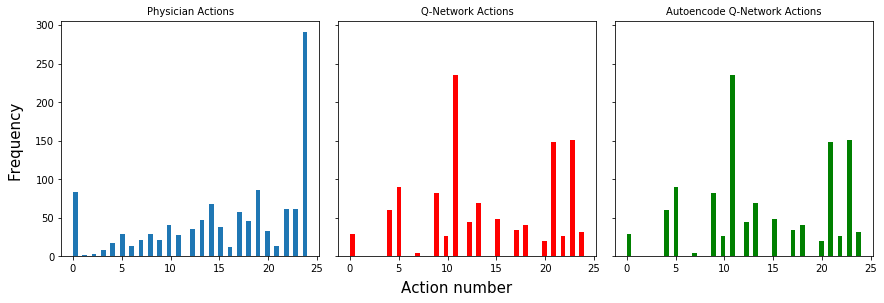

In [134]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12,4))
ax1.hist(phys_actions, bins=50)
ax1.set_title("Physician Actions", fontsize = 10)
ax2.hist(deeprl2_actions, bins=50, color='r')
ax2.set_title("Q-Network Actions", fontsize = 10)
ax3.hist(autoencode_actions, bins=50, color='g')
ax3.set_title("Autoencode Q-Network Actions", fontsize = 10)
f.text(0.5, -0.03, 'Action number', ha='center', fontsize=15)
f.text(-0.02, 0.5, 'Frequency', va='center', rotation='vertical', fontsize = 15)
# ax2.hist(autoencode_actions, bins=25, color ='g')
plt.tight_layout()


In [135]:
def make_df_diff(op_actions):
    op_vaso_med = []
    op_iv_med = []
    for action in op_actions:
        iv,vaso = inv_action_map[action]
        op_vaso_med.append(vaso_vals[vaso])
        op_iv_med.append(iv_vals[iv])
    iv_diff = np.array(op_iv_med) - np.array(df_test_orig['input_4hourly_tev'])
    vaso_diff = np.array(op_vaso_med) - np.array(df_test_orig['max_dose_vaso'])
    df_diff = pd.DataFrame()
    df_diff['mort'] = np.array(df_test_orig['died_in_hosp'])
    df_diff['iv_diff'] = iv_diff
    df_diff['vaso_diff'] = vaso_diff
    return df_diff

In [136]:
from scipy.stats import sem
def make_iv_plot_data(df_diff):
    bin_medians_iv = []
    mort_iv = []
    mort_std_iv= []
    i = -800
    while i <= 900:
        count =df_diff.loc[(df_diff['iv_diff']>i-50) & (df_diff['iv_diff']<i+50)]
        try:
            res = sum(count['mort'])/float(len(count))
            if len(count) >=2:
                bin_medians_iv.append(i)
                mort_iv.append(res)
                mort_std_iv.append(sem(count['mort']))
        except ZeroDivisionError:
            pass
        i += 100
    return bin_medians_iv, mort_iv, mort_std_iv

In [137]:
from scipy.stats import sem
def make_vaso_plot_data(df_diff):
    bin_medians_vaso = []
    mort_vaso= []
    mort_std_vaso= []
    i = -0.6
    while i <= 0.8:
        count =df_diff.loc[(df_diff['vaso_diff']>i-0.05) & (df_diff['vaso_diff']<i+0.05)]
        try:
            res = sum(count['mort'])/float(len(count))
            if len(count) >=2:
                bin_medians_vaso.append(i)
                mort_vaso.append(res)
                mort_std_vaso.append(sem(count['mort']))
        except ZeroDivisionError:
            pass
        i += 0.1
    return bin_medians_vaso, mort_vaso, mort_std_vaso

In [138]:
df_diff_autoencode = make_df_diff(autoencode_actions)
df_diff_deeprl2 = make_df_diff(deeprl2_actions)

In [139]:
bin_med_iv_auto, mort_iv_auto, mort_std_iv_auto = make_iv_plot_data(df_diff_autoencode)
bin_med_iv_deep, mort_iv_deep, mort_std_iv_deep = make_iv_plot_data(df_diff_deeprl2)
bin_med_vaso_auto, mort_vaso_auto, mort_std_vaso_auto = make_vaso_plot_data(df_diff_autoencode)
bin_med_vaso_deep, mort_vaso_deep, mort_std_vaso_deep = make_vaso_plot_data(df_diff_deeprl2)

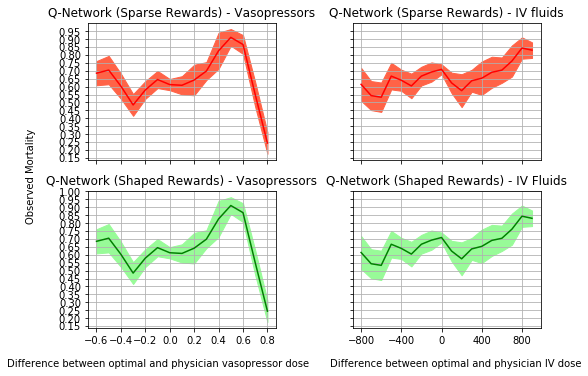

In [140]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize = (7.5,5))
ax1.plot(bin_med_vaso_deep, sliding_mean(mort_vaso_deep), color='r')
ax1.fill_between(bin_med_vaso_deep, sliding_mean(mort_vaso_deep) - 1*mort_std_vaso_deep,  
                 sliding_mean(mort_vaso_deep) + 1*mort_std_vaso_deep, color='tomato')
ax1.set_title('Q-Network (Sparse Rewards) - Vasopressors')
x_r = [i/10.0 for i in range(-6,10,2)]
y_r = [i/20.0 for i in range(0,20,1)]
ax1.set_xticks(x_r)
ax1.set_yticks(y_r)
ax1.grid()

ax2.plot(bin_med_iv_deep, sliding_mean(mort_iv_deep), color='r')
ax2.fill_between(bin_med_iv_deep, sliding_mean(mort_iv_deep) - 1*mort_std_iv_deep,  
                 sliding_mean(mort_iv_deep) + 1*mort_std_iv_deep, color='tomato')
ax2.set_title('Q-Network (Sparse Rewards) - IV fluids')
x_iv = [i for i in range(-800,900,400)]
ax2.set_xticks(x_iv)
ax2.grid()

ax3.plot(bin_med_vaso_auto, sliding_mean(mort_vaso_auto), color='g')
ax3.fill_between(bin_med_vaso_auto, sliding_mean(mort_vaso_auto) - 1*mort_std_vaso_auto,  
                 sliding_mean(mort_vaso_auto) + 1*mort_std_vaso_auto, color='palegreen')
y_auto = [i/20.0 for i in range(0,21,1)]
ax3.set_yticks(y_auto)
ax3.set_title('Q-Network (Shaped Rewards) - Vasopressors')
ax3.grid()

ax4.plot(bin_med_iv_auto, sliding_mean(mort_iv_auto), color='g')
ax4.fill_between(bin_med_iv_auto, sliding_mean(mort_iv_auto) - 1*mort_std_iv_auto,  
                 sliding_mean(mort_iv_auto) + 1*mort_std_iv_auto, color='palegreen')
ax4.set_title('Q-Network (Shaped Rewards) - IV Fluids')
ax4.grid()
plt.tight_layout()
f.text(0.225, -0.03, 'Difference between optimal and physician vasopressor dose', ha='center', fontsize=10)
f.text(0.775, -0.03, 'Difference between optimal and physician IV dose', ha='center', fontsize=10)
f.text(-0.02, 0.5, 'Observed Mortality', va='center', rotation='vertical', fontsize = 10)